In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


### Import plotting utilities and planar drone locally or from github

In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

# Downward facing constant altitude monocular camera

Here we have a single camera pointed down, moving laterally at constant altitude.

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{g} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
0 \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
1 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{u}
$

We have 1 measurement, the ventral optic flow. We can also assume we have lateral acceleration measurements, but in this case the acceleration is entirely defined by the control inputs we don't have to add it explicitly.

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{g/z} \\[0.3em]
\end{bmatrix}
$

# Dynamics and measurement functions

In [10]:
def f(x, u):
    g, z = np.ravel(x)
    j1, = np.ravel(u)
    xdot = np.array([j1, 0])
    return xdot

In [406]:
def h(x, u):
    g, z = np.ravel(x)
    y = np.array([g/z])
    return y

# Run MPC simulation

In [407]:
tsim_length = 20
rterm = 1e-2

In [408]:
state_names = ['g', 'z']
input_names = ['j1']
measurement_names = ['optic_flow']

dt = 0.1

simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names, 
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=int(1/dt))

tsim = np.arange(0, tsim_length, step=dt)

setpoint = {'g': 2.0*np.cos(2*np.pi*tsim*0.3),
            'z': 0*tsim + 1,
           }
       
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

cost_g = (simulator.model.x['g'] - simulator.model.tvp['g_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost = cost_g + cost_z 


# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=rterm)

# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

### Plot the ground speed and altitude

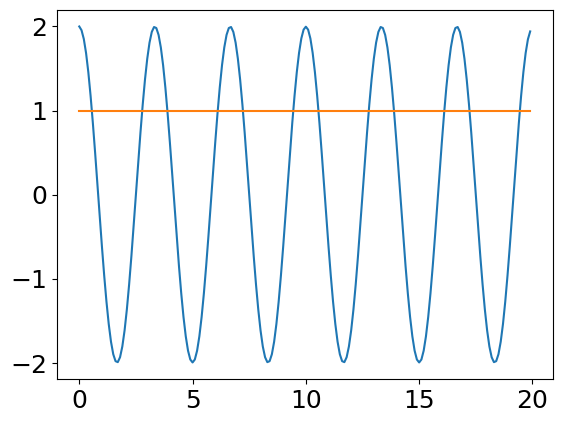

In [409]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_sim, x_sim['g'])
ax.plot(t_sim, x_sim['z'])

# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [410]:
measurement_noise_stds = {'optic_flow': 0.2,
                         }

In [411]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

<Axes: xlabel='Time', ylabel='optic_flow'>

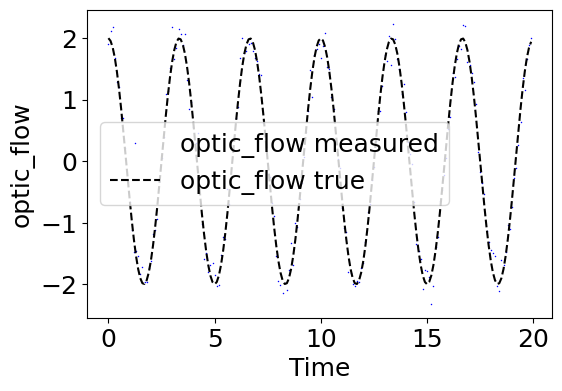

In [412]:
plot_tme(t_sim, y_sim['optic_flow'], y_noisy['optic_flow'], label_var='optic_flow')

### Save data as dataframes

In [413]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Kalman filter parameters and initilization

In [414]:
x0 = np.ones(len(x_sim))*2
u0 = np.zeros(1)
P0 = np.eye(len(x_sim))*1

In [415]:
R = np.diag( list(measurement_noise_stds.values()) )**2
Q = np.diag([1e-4]*len(x0))

In [416]:
dt = np.mean(np.diff(t_sim))

# Extended Kalman Filter

In [417]:
EKF = extended_kalman_filter.EKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt)

In [418]:
EKF.estimate(y_noisy_df, u_sim_df)

In [419]:
EKF.history.keys()

dict_keys(['X', 'U', 'Z', 'P', 'P_diags', 'R', 'Q', 'F', 'H', 'S', 'K', 'E', 'rho', 'Jk', 'inv_Jk'])

In [420]:
# State estimate
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=state_names)

In [421]:
# Covariance diagonals
P_diags = np.vstack([np.diag(EKF.history['P'][i]) for i in range(len(EKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=state_names)

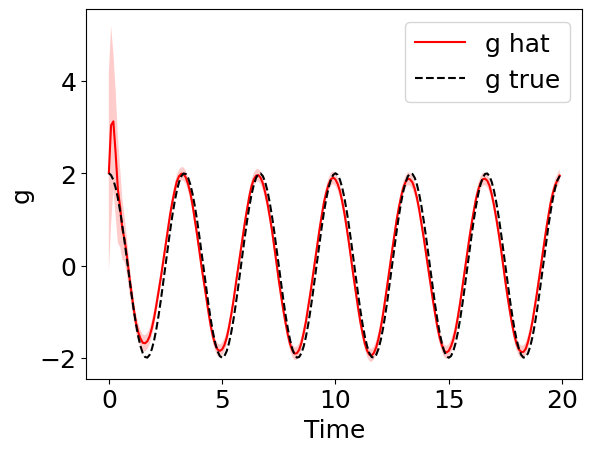

In [422]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'g'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

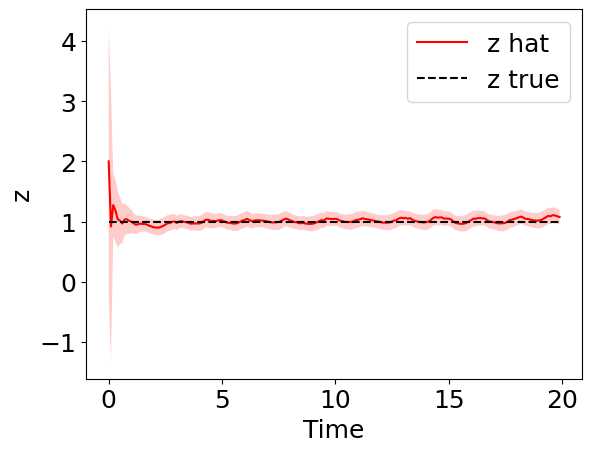

In [423]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Unscented Kalman Filter

In [424]:
UKF = unscented_kalman_filter.UKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 alpha=0.1) # <<<< determines how spread out the sigma points are

In [425]:
UKF.estimate(y_noisy_df, u_sim_df)

In [426]:
UKF.history.keys()

dict_keys(['X', 'P', 'P_diags', 'sigma_points'])

In [427]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=state_names)

In [428]:
# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=state_names)

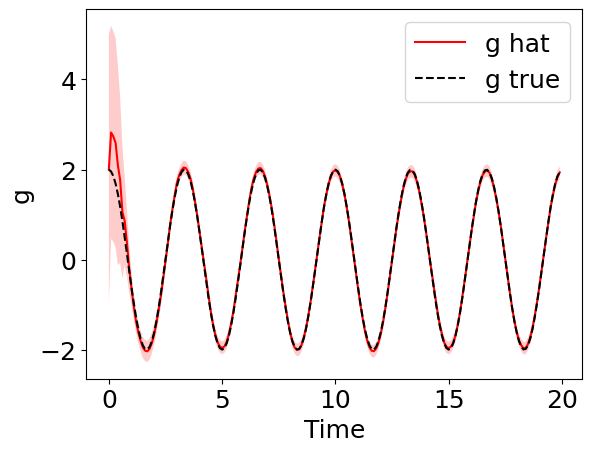

In [429]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'g'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

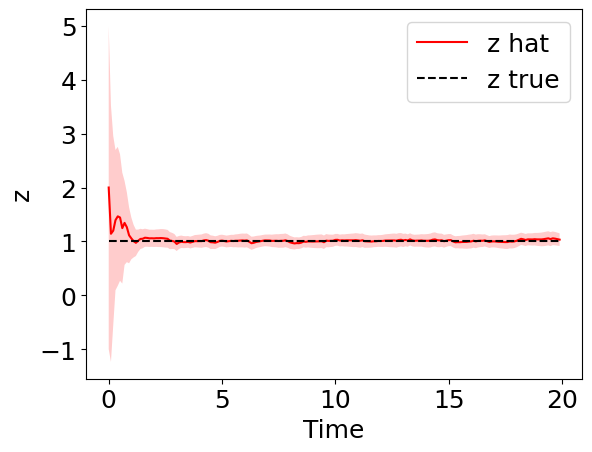

In [430]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

### Look at the sigma points

(0.9, 1.1)

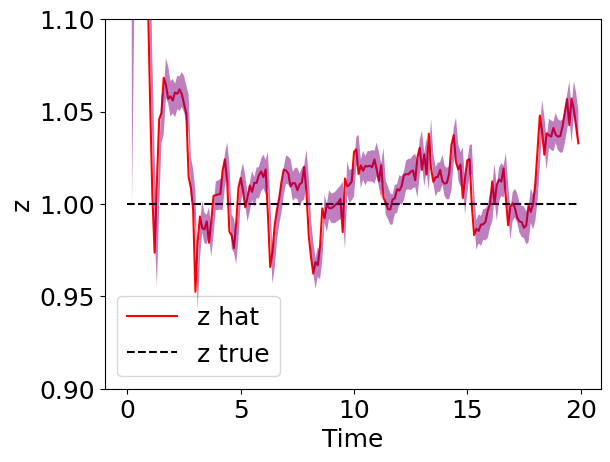

In [431]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

state_ix = state_names.index(state)

sigma_lo = UKF.history['sigma_points'][state_ix,0,:]
sigma_hi = UKF.history['sigma_points'][state_ix,-1,:]
ax.fill_between(t_sim[1:], sigma_lo, sigma_hi, facecolor='purple', edgecolor='none', alpha=0.5, zorder=100)

ax.set_ylim([0.9, 1.1])

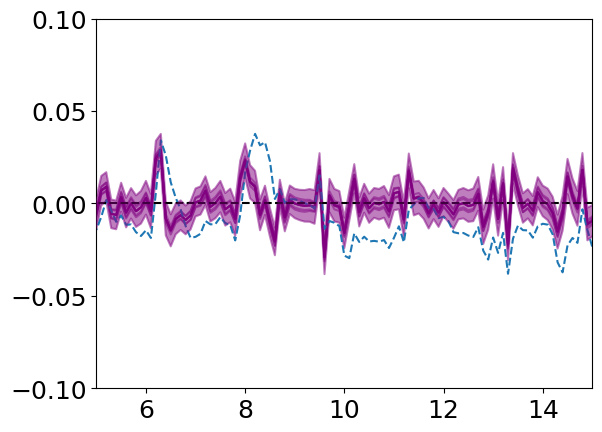

In [432]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'
state_ix = state_names.index(state)

# magnify the sigma points so they are easier to see
scaling = 1

sigma_lo = UKF.history['sigma_points'][state_ix,0,:]
sigma_hi = UKF.history['sigma_points'][state_ix,-1,:]
ax.fill_between(t_sim[1:],  scaling*(sigma_lo - x_est[state][1:]), scaling*(sigma_hi -  x_est[state][1:]), 
                facecolor='purple', edgecolor='none', alpha=0.5, zorder=100)

for s in range(len(UKF.history['sigma_points'][state_ix,:,0])):
    sigma = UKF.history['sigma_points'][state_ix,s,:]
    ax.plot(t_sim[1:],   scaling*(sigma - x_est[state][1:]), color='purple', alpha=0.5)

ax.plot(t_sim, x_sim[state] - x_est[state], '--')

ax.set_ylim([-0.1, .1])
ax.set_xlim(5, 15)

ax.hlines([0,], 0, 20, linestyles=['--',], color='black')